In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from util import parse_ingredient_list
from itertools import chain
import re
import json
import nltk
import pycrfsuite
import spacy.lang.en

In [2]:
# load one of the datasets to look at
file_name = "recipes_raw_nosource_ar"
df = pd.read_json("data/"+file_name+".json")
df.head()

,../AFIrLizRK7C5isREQ0hUdXoNXTpS,..3M3xsVPQLnncQ2oYzCyhGjNe/6EB2,..64QbeV22IrPuRAdLu4zscfAjsaFaK,..6gl/0GIzSugrbvy6kHyxEHMMP4h9K,..B3IS4KrEGWH7o13lvV9nQSe9a4u36,..G2iuRLT7oseNmkKbjqAgbdB1G5IBC,..M776r8BHroHcCXw3vInfs25LDkWw2,..VDFobAHiAa0127h.N784Y2pnZyBZK,..hYtxdDoy5Rp..pLgIj2mKKfvp1jPa,..r9vTQ.rPxKBEmr5CeouYRueErDR9u,...,zzQI40IqH266Q/7aL2dNUcSLDfAw5TK,zzSHIhnBtnBz777ZKFY2M3z.ohnLwtm,zzbj22/DDmvJZum5LsBbXj8MfckHzBO,zzkKyv6S9eERX/S2GPg6zuLy.UUY3Ya,zzor9kQO5E07Pn81ENqTxc4VA1ivct2,zzp8k7XnnQzjZgsZZgvbBwjwdCV7UOy,zzrUjH6/V3BmYZ/PufrjaI28bG.y8fe,zzsdaZomiWhwU0uej/xv4WHFV.T5Yq.,zzu0ElHFK71GznRt6JcB9vRym3/M1le,zzwS69D.4D3Ygbw0sZ4Sp.5t0KdUTYi
ingredients,[2 1/2 cups creamy salad dressing (such as Mir...,"[1 3/4 cups white sugar, 8 cups water, 1 1/2 c...","[2 cups baking mix, 1/2 cup shredded Cheddar c...","[2 teaspoons olive oil, 1 cup chopped onion, 2...","[1/2 cup uncooked long-grain rice, 6 slices ba...","[10 fresh tomatillos, husks removed, 3 cloves ...","[1 pound ground beef, 1 onion, chopped, 1 (14....","[1/2 pound uncooked medium shrimp, peeled and ...","[1 onion, quartered, 2 fresh green chile peppe...","[1/4 cup butter, 1/2 cup chopped carrots, 1/2 ...",...,"[1 cup cornmeal, 2 teaspoons ground cayenne pe...","[1/4 cup prepared salsa, 1 1/2 tablespoons shr...","[1 pound lean ground beef, 1 pound lean ground...","[1 tablespoon vegetable oil, 1 onion, chopped,...","[2 tablespoons sesame oil, 1 tablespoon brown ...","[1 cup ice cubes, 6 chunks fresh pineapple, 3 ...","[1 3/4 cups granulated sugar, 4 eggs, 4 ounces...","[1 (18.25 ounce) package white cake mix, 1 tea...","[1 1/2 cups water, 1 1/2 cups white sugar, 1 (...","[1 (18.25 ounce) package yellow cake mix, 3 eg..."
instructions,"Mix creamy salad dressing, mustard, sugar, and...","In a small saucepan, combine sugar and 1 cup w...",Preheat an oven to 450 degrees F (230 degrees ...,"In a large saucepan, heat oil over medium heat...",Preheat oven to 350 degrees F (175 degrees C)....,"Bring the tomatillos, garlic cloves, and water...","In a large saucepan over medium-high heat, coo...","Place the shrimp, shallot, 1 clove of garlic, ...","Blend the onion, green chile peppers, mint, le...",Melt butter in large saucepan over medium heat...,...,"In a mixing bowl, stir together cornmeal, caye...",Preheat oven to 375 degrees F (190 degrees C)....,"In a large stock pot over medium heat, brown t...","In large saucepan, heat oil over medium heat; ...",Heat the sesame oil in a large skillet over me...,Divide ice cubes between 2 martini glasses to ...,"Combine the granulated sugar, eggs, melted cho...",Grease and flour two 9 inch pans. Prepare cake...,"Combine the water, sugar, ginger, salt, and li...",Preheat oven to 350 degrees F (175 degrees C)....
picture_link,C0dLeqJsHiETBZCxg4uw0aqGvrSjRea,yjOAxAZN21c1IpdKlxm/AXmuxqW2dz.,i15jQbCInVmWa4z/CZbfodtgmapiGlG,hirHYG7xYneTopSvOWRmO5vgv81gR8C,c7O73YtdFisiVWx9Hetm6YiCV/zPZA.,OMYSXuFXYpYbXehIDrOOgj8oj7WQEki,aj./uBh.r3nGhTNH/K5RhCVaYOChpS2,MeEgA1rybCmDKGORjjn0h8RW2FpkGC6,fs4UZW7cHDQdzGNt/TWKUkT0HLVD31y,cH1T70Drd2oK8fY6HrVr25u0vbDhPf6,...,cnUsX.u0W5EGqDZvMPdTCslIPmF2QBW,./lHrbu3IthePiUvtCH6c4nO0fDf6za,nxmhzsWZRIrjoOMo8UUKBttikgEGzg2,CFa1fSzQ.JteZcdSgjWzsKG8qrvBPJK,drfDSrS/fHI4sCDoTqYkaVqMVKHRkjW,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,Vu/f9S95lEQakSNV540dUA5SQje63oi,fjzMGNfR3lBeijCn98DKs12ASqiMPsS,GKA98G/FHvqnY1yFOnGqcy0bXnIUALS,TAoVBMrlGtKB9Q34uJ5Jca1H/0y6e1e
title,Creamy Deviled Egg Salad,Best Lemonade Ever,Cheddar Beer Triangles,Sicilian Lentil Pasta Sauce,Broccoli Cheese Casserole,Salsa de Tomatillos Como Las Asadas y Big Star,Melanie's Chili,"Dee's Sexy, Spicy, Shrimp, Sausage, and Peppers",Minty Mint Chutney,Artichoke Soup,...,Pan Fried Catfish Filets,Cheese Quesadilla Lunch,Doug's Killer Sauce,Black Bean Vegetable Soup,Japanese Spinach with Sweet Sesame Seeds,Golden Tropical Cocktail,Chocolate Mint Crinkle Cookies,Coconut Sour Cream Cake,"Orange, Mango, and Ginger Sorbet",Apple Cake III


In [3]:
# For the moment we are not interested in the instructions or picture_link
df.drop(["instructions", "picture_link"], inplace=True)
df.head()

,../AFIrLizRK7C5isREQ0hUdXoNXTpS,..3M3xsVPQLnncQ2oYzCyhGjNe/6EB2,..64QbeV22IrPuRAdLu4zscfAjsaFaK,..6gl/0GIzSugrbvy6kHyxEHMMP4h9K,..B3IS4KrEGWH7o13lvV9nQSe9a4u36,..G2iuRLT7oseNmkKbjqAgbdB1G5IBC,..M776r8BHroHcCXw3vInfs25LDkWw2,..VDFobAHiAa0127h.N784Y2pnZyBZK,..hYtxdDoy5Rp..pLgIj2mKKfvp1jPa,..r9vTQ.rPxKBEmr5CeouYRueErDR9u,...,zzQI40IqH266Q/7aL2dNUcSLDfAw5TK,zzSHIhnBtnBz777ZKFY2M3z.ohnLwtm,zzbj22/DDmvJZum5LsBbXj8MfckHzBO,zzkKyv6S9eERX/S2GPg6zuLy.UUY3Ya,zzor9kQO5E07Pn81ENqTxc4VA1ivct2,zzp8k7XnnQzjZgsZZgvbBwjwdCV7UOy,zzrUjH6/V3BmYZ/PufrjaI28bG.y8fe,zzsdaZomiWhwU0uej/xv4WHFV.T5Yq.,zzu0ElHFK71GznRt6JcB9vRym3/M1le,zzwS69D.4D3Ygbw0sZ4Sp.5t0KdUTYi
ingredients,[2 1/2 cups creamy salad dressing (such as Mir...,"[1 3/4 cups white sugar, 8 cups water, 1 1/2 c...","[2 cups baking mix, 1/2 cup shredded Cheddar c...","[2 teaspoons olive oil, 1 cup chopped onion, 2...","[1/2 cup uncooked long-grain rice, 6 slices ba...","[10 fresh tomatillos, husks removed, 3 cloves ...","[1 pound ground beef, 1 onion, chopped, 1 (14....","[1/2 pound uncooked medium shrimp, peeled and ...","[1 onion, quartered, 2 fresh green chile peppe...","[1/4 cup butter, 1/2 cup chopped carrots, 1/2 ...",...,"[1 cup cornmeal, 2 teaspoons ground cayenne pe...","[1/4 cup prepared salsa, 1 1/2 tablespoons shr...","[1 pound lean ground beef, 1 pound lean ground...","[1 tablespoon vegetable oil, 1 onion, chopped,...","[2 tablespoons sesame oil, 1 tablespoon brown ...","[1 cup ice cubes, 6 chunks fresh pineapple, 3 ...","[1 3/4 cups granulated sugar, 4 eggs, 4 ounces...","[1 (18.25 ounce) package white cake mix, 1 tea...","[1 1/2 cups water, 1 1/2 cups white sugar, 1 (...","[1 (18.25 ounce) package yellow cake mix, 3 eg..."
title,Creamy Deviled Egg Salad,Best Lemonade Ever,Cheddar Beer Triangles,Sicilian Lentil Pasta Sauce,Broccoli Cheese Casserole,Salsa de Tomatillos Como Las Asadas y Big Star,Melanie's Chili,"Dee's Sexy, Spicy, Shrimp, Sausage, and Peppers",Minty Mint Chutney,Artichoke Soup,...,Pan Fried Catfish Filets,Cheese Quesadilla Lunch,Doug's Killer Sauce,Black Bean Vegetable Soup,Japanese Spinach with Sweet Sesame Seeds,Golden Tropical Cocktail,Chocolate Mint Crinkle Cookies,Coconut Sour Cream Cake,"Orange, Mango, and Ginger Sorbet",Apple Cake III


In [4]:
# Select a subset of data to look at, we transpose the original data frame
# so we can select all the values in a column at once.
df_trans = df.transpose()
# drop the recipes that have NaN for their ingredients
df_trans = df_trans[df_trans.ingredients.notnull()]

In [5]:
df_trans.head()

,ingredients,title
../AFIrLizRK7C5isREQ0hUdXoNXTpS,[2 1/2 cups creamy salad dressing (such as Mir...,Creamy Deviled Egg Salad
..3M3xsVPQLnncQ2oYzCyhGjNe/6EB2,"[1 3/4 cups white sugar, 8 cups water, 1 1/2 c...",Best Lemonade Ever
..64QbeV22IrPuRAdLu4zscfAjsaFaK,"[2 cups baking mix, 1/2 cup shredded Cheddar c...",Cheddar Beer Triangles
..6gl/0GIzSugrbvy6kHyxEHMMP4h9K,"[2 teaspoons olive oil, 1 cup chopped onion, 2...",Sicilian Lentil Pasta Sauce
..B3IS4KrEGWH7o13lvV9nQSe9a4u36,"[1/2 cup uncooked long-grain rice, 6 slices ba...",Broccoli Cheese Casserole


In [6]:
import utils
tagger = pycrfsuite.Tagger()
tagger.open('trained_pycrfsuite')

nlp_engine = spacy.lang.en.English()

from nltk.tokenize import PunktSentenceTokenizer
tokenizer = PunktSentenceTokenizer()

def sent2labels(sent):
    return [word[-1] for word in sent]

def sent2features(sent):
    return [word[:-1] for word in sent]

def sent2tokens(sent):
    return [word[0] for word in sent]   

def get_sentence_features(sent):
    """Gets  the features of the sentence"""
    sent_tokens = utils.tokenize(utils.cleanUnicodeFractions(sent))

    sent_features = []
    for i, token in enumerate(sent_tokens):
        token_features = [token]
        token_features.extend(utils.getFeatures(token, i+1, sent_tokens))
        sent_features.append(token_features)
    return sent_features

def format_ingredient_output(tagger_output, display=False):
    """Formats the tagger output into a more convenient dictionary"""
    data = [{}]
    display = [[]]
    prevTag = None

    
    for token, tag in tagger_output:
    # turn B-NAME/123 back into "name"
        tag = re.sub(r'^[BI]\-', "", tag).lower()
        # ---- DISPLAY ----
        # build a structure which groups each token by its tag, so we can
        # rebuild the original display name later.

        if prevTag != tag:
            display[-1].append((tag, [token]))
            prevTag = tag
        else:
            display[-1][-1][1].append(token)
            #               ^- token
            #            ^---- tag
            #        ^-------- ingredient

            # ---- DATA ----
            # build a dict grouping tokens by their tag

            # initialize this attribute if this is the first token of its kind
        if tag not in data[-1]:
            data[-1][tag] = []

        # HACK: If this token is a unit, singularize it so Scoop accepts it.
        if tag == "unit":
            token = utils.singularize(token)

        data[-1][tag].append(token)

    # reassemble the output into a list of dicts.
    output = [
        dict([(k, utils.smartJoin(tokens)) for k, tokens in ingredient.items()])
        for ingredient in data
        if len(ingredient)
    ]
    
    # Add the raw ingredient phrase
    for i, v in enumerate(output):
        output[i]["input"] = utils.smartJoin(
            [" ".join(tokens) for k, tokens in display[i]])

    return output

def parse_ingredient(sent):
    """ingredient parsing logic"""
    sentence_features = get_sentence_features(sent)
    tags = tagger.tag(sentence_features)
    tagger_output = zip(sent2tokens(sentence_features), tags)
    parsed_ingredient =  format_ingredient_output(tagger_output)
    if parsed_ingredient:
        parsed_ingredient[0]['name'] = parsed_ingredient[0].get('name','').strip('.')
    return parsed_ingredient

In [7]:
def parse_recipe_ingredients(ingredient_list):
    """Wrapper around parse_ingredient so we can call it on an ingredient list"""
    #sentences = tokenizer.tokenize(q)
    sentences = tokenizer.tokenize(ingredient_list)
    sentences = [sent.strip('\n') for sent in sentences]
    ingredients = []
    for sent in sentences:
        ingredients.extend(parse_ingredient(sent))
    return ingredients

def is_seperator(ingredient_string):
    return (
        ingredient_string.find("For ") == 0
        or " " not in ingredient_string
        or (":" in ingredient_string and "eg:" not in ingredient_string)
    )

In [8]:
s = "2 (10.75 ounce) cans condensed cream of mushr"
pattern = re.compile(r'([0-9]+)\s\(([0-9\.\sa-z]+)\)\s(\w+)')
match = re.sub(pattern, lambda x: str(int(x.group(1))*float(x.group(2).split()[0])) + " " + x.group(2).split()[1], s)
print(match)

21.5 ounce condensed cream of mushr


In [9]:

pattern1 = re.compile(r'([0-9]+)\s\(([0-9\.]+\s[a-z]+)\)\s(\w+)')
pattern2 = re.compile(r'^([0-9]+)\s\(*([0-9\.\s\/]+)[\s\-](inch)[\sa-z]*\)*')

def parse_list(recipe_index, recipe_title, ingredient_list):
    if isinstance(ingredient_list, list):
        ingredients=[]
        for ingredient_string in ingredient_list:
            # check if not ingredient, but separator
            # e.g. "For Bread:"
            if is_seperator(ingredient_string):
                continue
                
            if "skewers" in ingredient_string:
                continue
                
            if "canning jars" in ingredient_string:
                continue
                
            # remove trademark symbols
            ingredient_string = ingredient_string.replace("\u00ae", "")
            ingredient_string = ingredient_string.replace("(TM)", "")
            ingredient_string = ingredient_string.replace("™", "")
            
            ingredient_string = re.sub(pattern1, lambda x: str(int(x.group(1))*float(x.group(2).split()[0])) + " " + x.group(2).split()[1], ingredient_string)
            match = re.search(pattern2, ingredient_string)
            if match:
                try:
                    qty = float(match.group(1))
                    mult = match.group(2).split()
                    if len(mult) == 2:
                        qty *= float(mult[0]) + eval(mult[1])
                    else:
                        qty *= eval(mult[0])
                    ingredient_string = re.sub(pattern2, str(qty) + " " + "inch", ingredient_string)
                except ValueError:
                    pass
            
            ingredient = {}

            #ingr = ingre_text[2]
            #print(ingr)
            ingr_parse = parse_recipe_ingredients(ingredient_string)
            #print(ingr_parse)
            ingredient = ingr_parse[0]
            ingredient["title"] = recipe_title
            ingredient["index"] = recipe_index
            if "qty" not in ingredient and "other" in ingredient:
                try:
                    ingredient["qty"] = float(ingredient["other"])
                    ingredient["other"] = np.nan
                except ValueError:
                    pass
            if "qty" in ingredient:
                if not isinstance(ingredient["qty"], float):
                    if "$" in ingredient["qty"]:
                        try:
                            frac = ingredient["qty"].split("$")
                            ingredient["qty"] = float(frac[0])+eval(frac[1])
                        except (ValueError, NameError):
                            pass
                    else:
                        try:
                            ingredient["qty"] = float(ingredient["qty"])
                        except ValueError:
                            ingredient["qty"] = np.nan
                            
                        

            ingredients.append(ingredient)
        return ingredients
    else:
        return recipe_index, recipe_title, None

In [10]:
vfunc = np.vectorize(parse_list)

ingredient_df = pd.DataFrame(
    list(
        chain.from_iterable(
            vfunc(
                df_trans.index.values,
                df_trans.title.values,
                df_trans["ingredients"].values,
            )
        )
    )
)
ingredient_df.set_index("index", inplace=True)

In [11]:

ingredient_df.head(10)


,comment,input,name,other,qty,range_end,title,unit
index,,,,,,,,
../AFIrLizRK7C5isREQ0hUdXoNXTpS,(such as Miracle Whip),2$1/2 cups creamy salad dressing (such as Mira...,creamy salad dressing,NaN,2.50,NaN,Creamy Deviled Egg Salad,cup
../AFIrLizRK7C5isREQ0hUdXoNXTpS,prepared yellow,3/4 cup prepared yellow mustard,mustard,NaN,NaN,NaN,Creamy Deviled Egg Salad,cup
../AFIrLizRK7C5isREQ0hUdXoNXTpS,NaN,1/4 cup white sugar,white sugar,NaN,NaN,NaN,Creamy Deviled Egg Salad,cup
../AFIrLizRK7C5isREQ0hUdXoNXTpS,NaN,2 tablespoons white vinegar,white vinegar,NaN,2.00,NaN,Creamy Deviled Egg Salad,tablespoon
../AFIrLizRK7C5isREQ0hUdXoNXTpS,hard-boiled peeled and cut into 1/4-inch slices,"12 hard-boiled eggs, peeled and cut into 1/4-i...",eggs,",",12.00,NaN,Creamy Deviled Egg Salad,NaN
..3M3xsVPQLnncQ2oYzCyhGjNe/6EB2,NaN,1$3/4 cups white sugar,white sugar,NaN,1.75,NaN,Best Lemonade Ever,cup
..3M3xsVPQLnncQ2oYzCyhGjNe/6EB2,NaN,8 cups water,water,NaN,8.00,NaN,Best Lemonade Ever,cup
..3M3xsVPQLnncQ2oYzCyhGjNe/6EB2,NaN,1$1/2 cups lemon juice,lemon juice,NaN,1.50,NaN,Best Lemonade Ever,cup
..64QbeV22IrPuRAdLu4zscfAjsaFaK,NaN,2 cups baking mix,baking mix,NaN,2.00,NaN,Cheddar Beer Triangles,cup


In [12]:
ingredient_df.qty.unique()

array([2.50000000e+00,            nan, 2.00000000e+00, 1.20000000e+01,
       1.75000000e+00, 8.00000000e+00, 1.50000000e+00, 1.00000000e+00,
       3.00000000e+00, 1.60000000e+01, 6.00000000e+00, 1.00000000e+01,
       1.05000000e+01, 4.00000000e+00, 1.45000000e+01, 1.50000000e+01,
       1.75000000e+01, 4.20000000e+01, 3.00000000e+01, 7.00000000e+00,
       1.25000000e+00, 2.50000000e-01, 3.50000000e+00, 1.40000000e+01,
       3.20000000e+01, 2.80000000e+01, 5.00000000e+00, 2.25000000e+00,
       7.00000000e-01, 4.50000000e+00, 1.07500000e+01, 3.10000000e+01,
       1.76000000e+01, 1.52500000e+01, 1.82500000e+01, 2.10000000e+01,
       3.60000000e+01, 9.00000000e+00, 2.00000000e+01, 2.40000000e+01,
       2.75000000e+00, 2.90000000e+01, 6.40000000e+01, 2.15000000e+01,
       4.80000000e+01, 6.30000000e+00, 1.55000000e+01, 1.90000000e+01,
       3.25000000e+00, 3.40000000e+00, 4.00000000e+01, 5.00000000e-01,
       2.80000000e+00, 1.80000000e+01, 2.60000000e+01, 2.50000000e+01,
      

In [14]:
# Now we convert as many units as possible to metric
ingredient_df.loc[ingredient_df.unit == "pound", "qty"] *= 453.592
ingredient_df.loc[ingredient_df.unit == "pound", "unit"] = "grams"

ingredient_df.loc[ingredient_df.unit == "teaspoon", "qty"] *= 4.92892
ingredient_df.loc[ingredient_df.unit == "teaspoon", "unit"] = "milliliters"

ingredient_df.loc[ingredient_df.unit == "tablespoon", "qty"] *= 14.7868
ingredient_df.loc[ingredient_df.unit == "tablespoon", "unit"] = "milliliters"

ingredient_df.loc[ingredient_df.unit == "cup", "qty"] *= 236.588
ingredient_df.loc[ingredient_df.unit == "cup", "unit"] = "milliliters"

ingredient_df.loc[ingredient_df.unit == "pinch", "qty"] *= 4.92892 * (1 / 16)
ingredient_df.loc[ingredient_df.unit == "pinch", "unit"] = "milliliters"

ingredient_df.loc[ingredient_df.unit == "dash", "qty"] *= 4.92892 * (1 / 8)
ingredient_df.loc[ingredient_df.unit == "dash", "unit"] = "milliliters"

ingredient_df.loc[ingredient_df.unit == "ounce", "qty"] *= 28.3495
ingredient_df.loc[ingredient_df.unit == "ounce", "unit"] = "grams"

ingredient_df.loc[ingredient_df.unit == "fluid ounce", "qty"] *= 29.5735
ingredient_df.loc[ingredient_df.unit == "fluid ounce", "unit"] = "milliliters"

ingredient_df.loc[ingredient_df.unit == "pint", "qty"] *= 473.176
ingredient_df.loc[ingredient_df.unit == "pint", "unit"] = "milliliters"

ingredient_df.loc[ingredient_df.unit == "quart", "qty"] *= 946.353
ingredient_df.loc[ingredient_df.unit == "quart", "unit"] = "milliliters"

ingredient_df.loc[ingredient_df.unit == "liter", "qty"] *= 1000
ingredient_df.loc[ingredient_df.unit == "liter", "unit"] = "milliliters"

ingredient_df.loc[ingredient_df.unit == "gallon", "qty"] *= 3785.41
ingredient_df.loc[ingredient_df.unit == "gallon", "unit"] = "milliliters"

ingredient_df.loc[ingredient_df.unit == "drop", "qty"] *= 0.05
ingredient_df.loc[ingredient_df.unit == "drop", "unit"] = "milliliters"

ingredient_df.loc[ingredient_df.unit == "jigger", "qty"] *= 44.3603
ingredient_df.loc[ingredient_df.unit == "jigger", "unit"] = "milliliters"

ingredient_df.head(10)

,comment,input,name,other,qty,range_end,title,unit
index,,,,,,,,
../AFIrLizRK7C5isREQ0hUdXoNXTpS,(such as Miracle Whip),2$1/2 cups creamy salad dressing (such as Mira...,creamy salad dressing,NaN,591.4700,NaN,Creamy Deviled Egg Salad,milliliters
../AFIrLizRK7C5isREQ0hUdXoNXTpS,prepared yellow,3/4 cup prepared yellow mustard,mustard,NaN,NaN,NaN,Creamy Deviled Egg Salad,milliliters
../AFIrLizRK7C5isREQ0hUdXoNXTpS,NaN,1/4 cup white sugar,white sugar,NaN,NaN,NaN,Creamy Deviled Egg Salad,milliliters
../AFIrLizRK7C5isREQ0hUdXoNXTpS,NaN,2 tablespoons white vinegar,white vinegar,NaN,29.5736,NaN,Creamy Deviled Egg Salad,milliliters
../AFIrLizRK7C5isREQ0hUdXoNXTpS,hard-boiled peeled and cut into 1/4-inch slices,"12 hard-boiled eggs, peeled and cut into 1/4-i...",eggs,",",12.0000,NaN,Creamy Deviled Egg Salad,NaN
..3M3xsVPQLnncQ2oYzCyhGjNe/6EB2,NaN,1$3/4 cups white sugar,white sugar,NaN,414.0290,NaN,Best Lemonade Ever,milliliters
..3M3xsVPQLnncQ2oYzCyhGjNe/6EB2,NaN,8 cups water,water,NaN,1892.7040,NaN,Best Lemonade Ever,milliliters
..3M3xsVPQLnncQ2oYzCyhGjNe/6EB2,NaN,1$1/2 cups lemon juice,lemon juice,NaN,354.8820,NaN,Best Lemonade Ever,milliliters
..64QbeV22IrPuRAdLu4zscfAjsaFaK,NaN,2 cups baking mix,baking mix,NaN,473.1760,NaN,Cheddar Beer Triangles,milliliters


In [15]:
ingredient_df.head()

,comment,input,name,other,qty,range_end,title,unit
index,,,,,,,,
../AFIrLizRK7C5isREQ0hUdXoNXTpS,(such as Miracle Whip),2$1/2 cups creamy salad dressing (such as Mira...,creamy salad dressing,NaN,591.4700,NaN,Creamy Deviled Egg Salad,milliliters
../AFIrLizRK7C5isREQ0hUdXoNXTpS,prepared yellow,3/4 cup prepared yellow mustard,mustard,NaN,NaN,NaN,Creamy Deviled Egg Salad,milliliters
../AFIrLizRK7C5isREQ0hUdXoNXTpS,NaN,1/4 cup white sugar,white sugar,NaN,NaN,NaN,Creamy Deviled Egg Salad,milliliters
../AFIrLizRK7C5isREQ0hUdXoNXTpS,NaN,2 tablespoons white vinegar,white vinegar,NaN,29.5736,NaN,Creamy Deviled Egg Salad,milliliters
../AFIrLizRK7C5isREQ0hUdXoNXTpS,hard-boiled peeled and cut into 1/4-inch slices,"12 hard-boiled eggs, peeled and cut into 1/4-i...",eggs,",",12.0000,NaN,Creamy Deviled Egg Salad,NaN


## The correlation 

#### First plot each attributes


In [16]:
ingredient_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 357928 entries, ../AFIrLizRK7C5isREQ0hUdXoNXTpS to zzwS69D.4D3Ygbw0sZ4Sp.5t0KdUTYi
Data columns (total 8 columns):
comment      174954 non-null object
input        357928 non-null object
name         357928 non-null object
other        72061 non-null object
qty          248872 non-null float64
range_end    17 non-null object
title        357928 non-null object
unit         296155 non-null object
dtypes: float64(1), object(7)
memory usage: 24.6+ MB


In [83]:
ingredient_df.shape
name  = ingredient_df['name']
title = ingredient_df['title']
unit  = ingredient_df['unit']

columns = [name,title,unit]

In [89]:
# ingredient_df.title.value_counts().compress(lambda s: s>=10).plot(kind='bar')
# plt.title('Count of Each Cuisine Name')
# plt.xlabel('Cuisine')
# plt.ylabel('Frequency')
# plt.show()

array(['Creamy Deviled Egg Salad', 'Best Lemonade Ever',
       'Cheddar Beer Triangles', ..., 'Coconut Sour Cream Cake',
       'Orange, Mango, and Ginger Sorbet', 'Apple Cake III'], dtype=object)

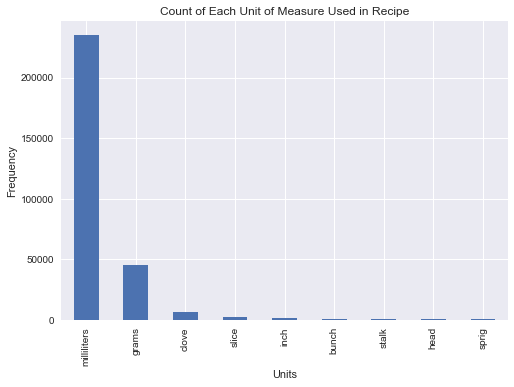

In [85]:
ingredient_df.unit.value_counts().compress(lambda s: s>=200).plot(kind='bar')
plt.title('Count of Each Unit of Measure Used in Recipe')
plt.xlabel('Units')
plt.ylabel('Frequency')
plt.show()

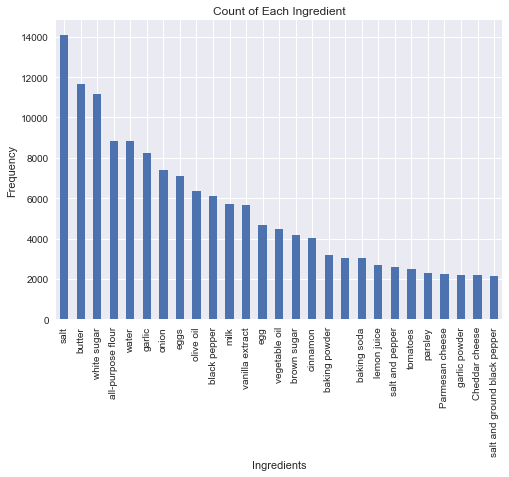

In [86]:
ingredient_df.name.value_counts().compress(lambda s: s>=2000).plot(kind='bar')
plt.title('Count of Each Ingredient')
plt.xlabel('Ingredients')
plt.ylabel('Frequency')
plt.show()


In [47]:
# Now we can explore the results of our parsing
print("Unique units of measurement:\n", ingredient_df.unit.unique())
print("Number of unique ingredients: ", len(ingredient_df.name.unique()))
ingredient_df.name.unique()
# temp_df = ingredient_df[ingredient_df.name.str.contains("honey")]
temp_df.name.unique()


Unique units of measurement:
 ['milliliters' nan 'clove' 'grams' 'slice' 'head' 'bunch' 'strip' 'inch'
 'sprig' 'stalk' 'package' 'packet' 'milliliter' 'scoop' 'ear' 'bulb'
 'pound fillet' 'piece' 'wedge' 'cup clove' 'sheet' 'gram' 'loaf' 'stick'
 'ounce fillet' 'splash' 'inch slice' 'fluid' 'envelope' 'ounce slice'
 'bunch stalk' 'fillet' 'cube' 'bottle' 'head clove' 'leaf' 'cup fillet'
 'clove clove' 'ball' 'ounce pound' 'rack' 'stalk stalk' 'bone'
 'bulb clove' 'box' 'square' 'bag' 'pound slice' 'cup slice'
 'cup teaspoon' 'link' 'head bulb' 'chunk' 'inch sprig' 'cup cup' 'jar']
Number of unique ingredients:  13004


array(['honey', 'honeydew melon', 'clover honey', 'honey mustard',
       'honey-flavored barbeque sauce', 'honeycomb beef tripe',
       'honey Dijon mustard', 'honey-glazed almonds', 'raw honey',
       'soft cream cheese with honey and nuts', 'honeydew',
       'avocado honey', 'honey-Dijon mustard',
       'honey mustard barbecue sauce', 'orange blossom honey',
       'white corn syrup or honey', 'fluid honey syrup',
       'honey- and herb-flavored whiskey liqueur', 'honey graham cereal',
       'honey mustard sauce', 'honey barbecue sauce',
       'honeydew melon balls', 'powdered honey', 'honey-flavored butter',
       'warm honey', 'unpasteurized honey', 'unpasteurized Manuka honey',
       'honey ham', 'liquid honey', 'honey mustard dressing',
       'honey (fireweed honey preferred)',
       'vanilla and honey Greek yogurt', 'honey garlic barbecue sauce',
       'honey graham crackers', 'honey barbeque sauce', 'honeycomb tripe',
       'wildflower honey', "Annie's Bunny Graha

In [211]:
# Now we make the real DataFrame that we will do most of our work with.
# In theory this should have worked with .pivot instead of .pivot_table,
# but it didn't. This makes me think there is a bug somewhere in how
# the recipes are being parsed but I will look into that later
# FYI this will take several minutes
recipe_df = ingredient_df.pivot_table(
    index="index", columns="name", values="qty", aggfunc=np.mean
)
recipe_df.fillna(0, inplace=True)
recipe_df.head(10)

name,,'bouqet garni' spice balls,(.68,(0.5 oz each) Cheddar cheese,(1 inch thick) beef top sirloin steak,(1 inch thick) steak fillet,(1$1/2-pound) boneless pork loin,(1$1/2-pound) boneless pork loin roast,(1$1/2-pound) flank steak,(1$1/2-pound) trimmed beef flank steak,...,zucchini matchsticks,zucchini or yellow summer squash,zucchini slices,zucchini squash,zucchini squashes,"zucchini, quartered lengthwise and then cut crosswise into 1/2-inch pieces","zucchini, sliced into long ribbons using a vegetable peeler",zucchinis,zwieback cracker crumbs,zwieback toast
index,,,,,,,,,,,,,,,,,,,,,
../AFIrLizRK7C5isREQ0hUdXoNXTpS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
..3M3xsVPQLnncQ2oYzCyhGjNe/6EB2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
..64QbeV22IrPuRAdLu4zscfAjsaFaK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
..6gl/0GIzSugrbvy6kHyxEHMMP4h9K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
..B3IS4KrEGWH7o13lvV9nQSe9a4u36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
..G2iuRLT7oseNmkKbjqAgbdB1G5IBC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
..M776r8BHroHcCXw3vInfs25LDkWw2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
..VDFobAHiAa0127h.N784Y2pnZyBZK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
..hYtxdDoy5Rp..pLgIj2mKKfvp1jPa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Let's save our dataframe so we can look at it without having to reload and recompute everything later.
# pickle is much faster than csv
recipe_df.to_pickle("data/"+file_name+"_parsed.pickle")

In [ ]:
# Here we compute the t-SNE
# WARNING: THIS TAKES A LONG TIME FOR LARGE DATAFRAMES
data = recipe_df[recipe_df.columns].values
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
tsne_results = tsne.fit_transform(data)
print("tsne done")
recipe_df["tsne-2d-one"] = tsne_results[:, 0]
recipe_df["tsne-2d-two"] = tsne_results[:, 1]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 39416 samples in 91.124s...


In [ ]:
# plot the t-SNE
plt.figure(figsize=(16, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=recipe_df, linewidth=0)
plt.show()

In [27]:
# Here I'm just exploring outliers in the t-SNE
sample_df = recipe_df.loc[recipe_df["tsne-2d-two"] <= -100]
drop_cols = sample_df.columns[(sample_df == 0).sum() == sample_df.shape[0]]
sample_df.drop(drop_cols, axis=1, inplace=True)
sample_df.columns.unique()


Index(['Golden Delicious apple', 'Italian bread',
       'Mexican cheese blend or more to taste', 'Parmesan cheese',
       'Romano cheese', 'all purpose apples', 'all purpose flour',
       'apple cider vinegar', 'baby back ribs', 'baking powder',
       ...
       'watermelon', 'whipped topping', 'white bread', 'white bread cubes',
       'white peaches', 'white sugar', 'white wine', 'whole wheat bread',
       'tsne-2d-one', 'tsne-2d-two'],
      dtype='object', name='ingredient', length=118)